In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import scipy 
import theano
from sklearn.metrics import mean_squared_error
from pymc3.ode import DifferentialEquation
from scipy.integrate import odeint
from random import seed
import scipy.optimize as opt
plt.style.use("seaborn-darkgrid")
from pymc3.distributions.timeseries import EulerMaruyama
import datetime
import pandas as pd
import plotly.express as px
px.defaults.height=600

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
Totales_Nacionales_Diarios = pd.read_csv("https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto5/TotalesNacionales.csv",index_col=0)

In [3]:
Total_poblacional = pd.read_csv("https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto1/Covid-19.csv",index_col=0)

Total_poblacional['Poblacion'].isna().sum()

16

In [4]:
len(Total_poblacional)-16

346

In [5]:
Total_poblacional=int(Total_poblacional['Poblacion'].sum())
Total_poblacional

19458310

In [6]:
df = Totales_Nacionales_Diarios.T

In [7]:
columnas_a = [
'Casos nuevos con sintomas'  
,'Casos totales'  
,'Casos recuperados'  
,'Fallecidos'  
,'Casos activos' 
,'Casos nuevos sin sintomas' 
,'Casos nuevos totales' 
,'Casos activos por FD' 
,'Casos activos por FIS' 
,'Casos recuperados por FIS' 
,'Casos recuperados por FD' 
,'Casos confirmados recuperados' 
,'Casos activos confirmados' 
,'Casos probables acumulados' 
,'Casos activos probables' 
,'Casos nuevos sin notificar' 
,'Casos confirmados por antigeno' 
,'Casos con sospecha de reinfeccion' 
,'Casos nuevos confirmados por antigeno' 
,'Fallecidos confirmados totales' 
,'Fallecidos sospechosos probables u otros totales' 
]

In [8]:
new = df[['Casos totales','Casos nuevos totales','Casos activos confirmados','Casos confirmados recuperados']].copy()
new=new/Total_poblacional
new.tail(10)

Fecha,Casos totales,Casos nuevos totales,Casos activos confirmados,Casos confirmados recuperados
2022-10-29,0.244151,0.000317,0.000978,0.239395
2022-10-30,0.244431,0.000269,0.000873,0.239774
2022-10-31,0.244635,0.000193,0.000714,0.240138
2022-11-01,0.244768,0.000130,0.000559,0.240426
2022-11-02,0.244930,0.000161,0.000471,0.240676
2022-11-03,0.245121,0.000188,0.000437,0.240901
2022-11-04,0.245510,0.000384,0.000637,0.241078
2022-11-05,0.245972,0.000449,0.000903,0.241260
2022-11-06,0.246368,0.000388,0.001028,0.241525
2022-11-07,0.246641,0.000263,0.001033,0.241787


In [9]:
new['Casos activos confirmados'].min()

0.00014955050053164947

In [10]:
new['Casos activos confirmados'].max()

0.0075933110326641936

In [11]:
Recuperados_diarios=new.diff()
Recuperados_diarios=Recuperados_diarios['Casos confirmados recuperados']
new['Recuperados diarios']=Recuperados_diarios

In [12]:
filtered_df=new.loc['2020-03-18':'2021-09-30']
filtered_df

Fecha,Casos totales,Casos nuevos totales,Casos activos confirmados,Casos confirmados recuperados,Recuperados diarios
2020-03-18,0.000012,0.000002,NaN,NaN,NaN
2020-03-19,0.000018,0.000005,NaN,NaN,NaN
2020-03-20,0.000022,0.000005,NaN,NaN,NaN
2020-03-21,0.000028,0.000005,NaN,NaN,NaN
2020-03-22,0.000032,0.000005,NaN,NaN,NaN
...,...,...,...,...,...
2021-09-26,0.084887,0.000040,0.000231,0.082585,0.000024
2021-09-27,0.084918,0.000033,0.000233,0.082612,0.000027
2021-09-28,0.084940,0.000023,0.000198,0.082668,0.000056
2021-09-29,0.084972,0.000027,0.000207,0.082690,0.000022


In [13]:
filtered_df_p1=new.loc['2020-07-01':'2020-10-31']
filtered_df_p1['S(t)']=1-filtered_df_p1['Casos activos confirmados']

filtered_df_p2=new.loc['2020-11-01':'2021-02-28']
filtered_df_p2['S(t)']=1-filtered_df_p2['Casos activos confirmados']

filtered_df_p3=new.loc['2021-03-01':'2021-06-30']
filtered_df_p3['S(t)']=1-filtered_df_p3['Casos activos confirmados']

filtered_df_p4=new.loc['2021-07-01':'2021-10-31']
filtered_df_p4['S(t)']=1-filtered_df_p4['Casos activos confirmados']

filtered_df_p5=new.loc['2021-11-01':'2022-02-28']
filtered_df_p5['S(t)']=1-filtered_df_p5['Casos activos confirmados']

filtered_df_total=new.loc['2020-07-01':'2022-03-01']
filtered_df_total['S(t)']=1-filtered_df_total['Casos activos confirmados']


C:\Users\sebas\AppData\Local\Temp\ipykernel_12504\1776581783.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_p1['S(t)']=1-filtered_df_p1['Casos activos confirmados']
C:\Users\sebas\AppData\Local\Temp\ipykernel_12504\1776581783.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_p2['S(t)']=1-filtered_df_p2['Casos activos confirmados']
C:\Users\sebas\AppData\Local\Temp\ipykernel_12504\1776581783.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

In [14]:
fig = px.line(filtered_df_total, x=filtered_df_total.index, y=['Casos activos confirmados', 'S(t)'])
newnames = {'Casos activos confirmados': "I(t)", 'S(t)': "S(t)"}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name],
                                      legendgroup = newnames[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])))

fig.update_layout(title='Casos Activos Confirmados, Períodos',xaxis_title='Tiempo',yaxis_title='Proporción poblacional')
fig.add_vline(x='2020-10-31', line_width=3, line_dash="dash", line_color="orange")
fig.add_vline(x='2021-02-28', line_width=3, line_dash="dash", line_color="brown")
fig.add_vline(x='2021-06-30', line_width=3, line_dash="dash", line_color="green")
fig.add_vline(x='2021-10-31', line_width=3, line_dash="dash", line_color="red")
fig.add_vline(x='2022-02-28', line_width=3, line_dash="dash", line_color="purple")

fig.show()

In [15]:
# cambiar los valores numericos con el periodo de estudio
periodo_t = "5"
periodo = filtered_df_p5

In [16]:
fig = px.line(periodo, x=periodo.index, y=['Casos activos confirmados', 'S(t)'])
newnames = {'Casos activos confirmados': "I(t)", 'S(t)': "S(t)"}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name],
                                      legendgroup = newnames[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])))

fig.update_layout(title='Casos Activos Confirmados, Período'+periodo_t,xaxis_title='Tiempo',yaxis_title='Proporción poblacional')

fig.show()

In [17]:
periodo.index.names = ['Fecha_indice']
periodo=periodo.reset_index()
periodo

Fecha,Fecha_indice,Casos totales,Casos nuevos totales,Casos activos confirmados,Casos confirmados recuperados,Recuperados diarios,S(t)
0,2021-11-01,0.087201,0.000093,0.000596,0.084462,0.000087,0.999404
1,2021-11-02,0.087270,0.000071,0.000574,0.084552,0.000090,0.999426
2,2021-11-03,0.087337,0.000070,0.000555,0.084637,0.000084,0.999445
3,2021-11-04,0.087434,0.000100,0.000573,0.084716,0.000079,0.999427
4,2021-11-05,0.087563,0.000134,0.000580,0.084832,0.000117,0.999420
...,...,...,...,...,...,...,...
115,2022-02-24,0.151806,0.001576,0.005454,0.143820,0.001657,0.994546
116,2022-02-25,0.153450,0.001497,0.005566,0.145343,0.001523,0.994434
117,2022-02-26,0.154979,0.001426,0.005623,0.146805,0.001461,0.994377
118,2022-02-27,0.156303,0.001224,0.005798,0.147944,0.001140,0.994202


In [18]:
# NOTA: fijar el seed SOLAMENTE si se estan probando diferentes modelos
# seed(2418)

# From now on we'll work with proportions instead of integer numbers
# i -> infectados/N
# Parameters: 
# beta = disease transmission rate
# gamma = recovery rate
# mu = mortality rate
# mu + beta = renewal rate
# theta = [beta - (mu+gamma), beta]
# Thus, if theta[0]<0, the disease will vanish and if theta[0]>0 we have persistence of the disease

i0 = periodo['Casos activos confirmados'][0] #0.2 # initial proportion of infected
Tf = len(periodo['Casos activos confirmados']) #20  # Terminal time
T0 = 0 # Initial time
Dt = 1 # time step

times = np.arange(T0, Tf, Dt) # time vector

In [19]:
len(times)

120

In [20]:
infected_obs=np.array(periodo['Casos activos confirmados'])

Text(0, 0.5, 'Proporción')

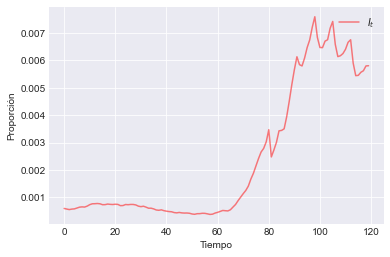

In [21]:
plt.plot(infected_obs, "r", label=r"$I_t$", alpha=0.5)
plt.xlabel("Tiempo")
plt.legend()
plt.ylabel("Proporción")

In [22]:
# ODEs model
def SISS(i, theta):
    di = (i[0]*(theta[0]-theta[1]*i[0])) 
    sigma1 =  theta[2] *( i[0]-i[0]**2)
    return di, sigma1

In [23]:
simga_2_ep = sum(np.diff(infected_obs)**2)/(Dt*sum((infected_obs**2)+(1-infected_obs)**2))
simga_ep=np.sqrt(simga_2_ep)
simga_ep

0.0002451541367431264

In [24]:
# Define pymc model and sampling the MC Markov chain
nb_chains = 2 #choose >1 to run some convergence diagnostics on the chains
len_chains = 15000
len_burning_states = 5000

In [25]:
with pm.Model() as model:
    theta_m = [0,0,0]
    theta_m[0] = pm.Normal("beta-(mu+gamma)",0,1) 
    theta_m[1] = pm.TruncatedNormal("beta", mu=5, sigma=10, lower=0)
    theta_m[2] = pm.HalfNormal("sigma",1) 
    eu = EulerMaruyama("EM", Dt, SISS, (theta_m,),shape=infected_obs.shape, observed=infected_obs)


In [26]:
with model:
    trace = pm.sample(len_chains, tune=len_burning_states, cores=1, init  = 'advi', chains=nb_chains,start={'sigma':simga_ep})
    data = az.from_pymc3(trace=trace)

C:\Users\sebas\AppData\Local\Temp\ipykernel_12504\2600213759.py:2: FutureWarning:

In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.

Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 10300
Interrupted at 10,299 [5%]: Average Loss = -759.6
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, beta, beta-(mu+gamma)]


Sampling 2 chains for 5_000 tune and 15_000 draw iterations (10_000 + 30_000 draws total) took 22 seconds.


WARN: Could not locate executable g77
WARN: Could not locate executable f77
WARN: Could not locate executable ifort
WARN: Could not locate executable ifl
WARN: Could not locate executable f90
WARN: Could not locate executable DF
WARN: Could not locate executable efl


The number of effective samples is smaller than 25% for some parameters.


In [27]:
a=az.summary(trace)
a

Got error No model on context stack. trying to find log_likelihood in translation.
c:\Users\sebas\anaconda3\envs\pymc_env\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning:

Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.



,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta-(mu+gamma),0.079,0.038,0.006,0.148,0.000,0.000,33338.0,21803.0,1.0
beta,10.198,7.174,0.001,22.780,0.081,0.057,5708.0,4655.0,1.0
sigma,0.411,0.027,0.360,0.462,0.000,0.000,24929.0,18763.0,1.0


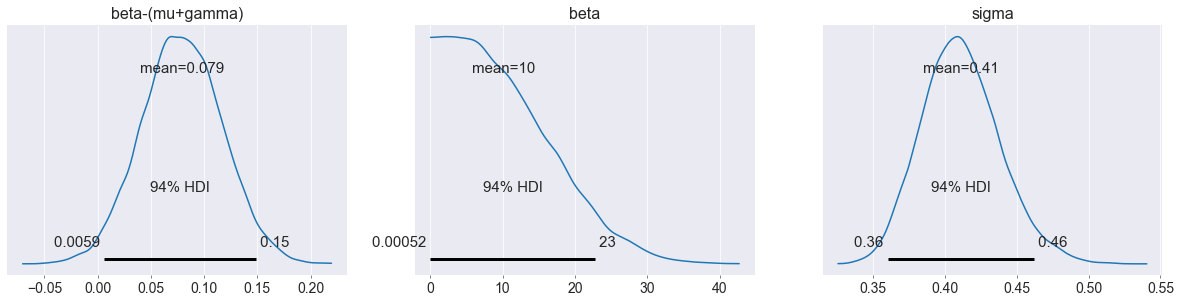

In [28]:
# Plot posterior densities
az.plot_posterior(data, 
                  var_names=["beta-(mu+gamma)", "beta","sigma"]);
plt.show()

Text(0, 0.5, 'MCMC promedio')

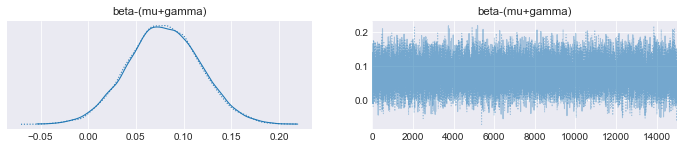

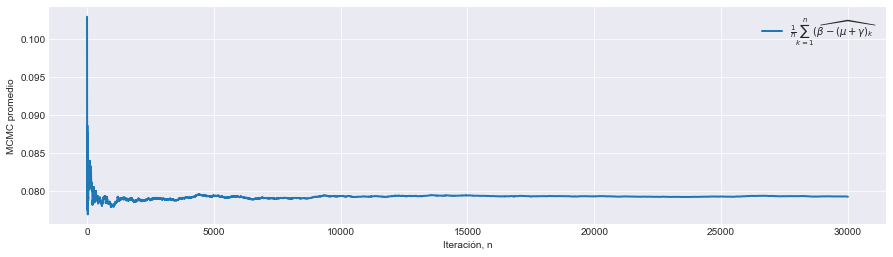

In [29]:
# plot the exploration for each chain and convergence of the ergodic mean
# beta - (mu+gamma)
az.plot_trace({"beta-(mu+gamma)": trace.get_values(varname="beta-(mu+gamma)", combine=False)})
mean_theta0 = [np.mean(trace['beta-(mu+gamma)'][:i]) for i in np.arange(1, len(trace['beta-(mu+gamma)']))]
plt.figure(figsize=(15, 4))
plt.plot(mean_theta0, lw=2, label=r"$\frac{1}{n}\sum_{k=1}^n\widehat{(\beta-(\mu+\gamma)}_k$")
plt.xlabel("Iteración, n")
plt.legend()
plt.ylabel("MCMC promedio")

Text(0, 0.5, 'MCMC promedio')

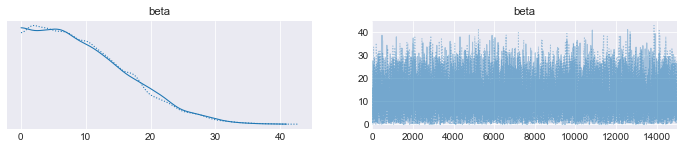

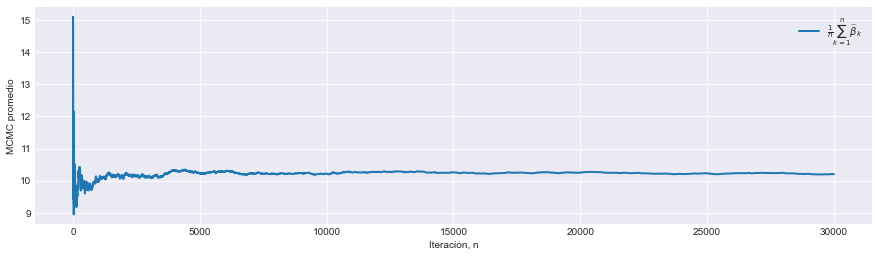

In [30]:
# beta
az.plot_trace({"beta": trace.get_values(varname="beta", combine=False)})
mean_theta1 = [np.mean(trace['beta'][:i]) for i in np.arange(1, len(trace['beta']))]
plt.figure(figsize=(15, 4))
plt.plot(mean_theta1, lw=2, label=r"$\frac{1}{n}\sum_{k=1}^n\widehat{\beta}_k$")
plt.xlabel("Iteración, n")
plt.legend()
plt.ylabel("MCMC promedio")

Text(0, 0.5, 'MCMC promedio')

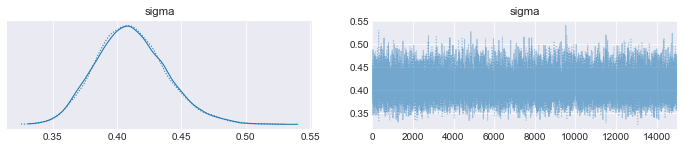

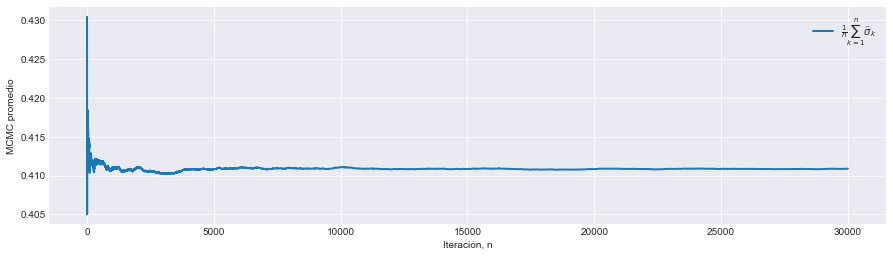

In [31]:
# sigma
az.plot_trace({"sigma": trace.get_values(varname="sigma", combine=False)})
mean_theta2 = [np.mean(trace['sigma'][:i]) for i in np.arange(1, len(trace['sigma']))]
plt.figure(figsize=(15, 4))
plt.plot(mean_theta2, lw=2, label=r"$\frac{1}{n}\sum_{k=1}^n\widehat{\sigma}_k$")
plt.xlabel("Iteración, n")
plt.legend()
plt.ylabel("MCMC promedio")

In [32]:
theta_est = [mean_theta0[-1],mean_theta1[-1],mean_theta2[-1]]

R_0 = 1+(theta_est[0]-0.5*theta_est[2]**2)/(theta_est[1]-theta_est[0])
R_0
if R_0 > 1:
    print('la enfermedad persiste')
else: 
    if theta_est[2]**2 <= theta_est[1]:
        print('la enfermedad se extingue')


if theta_est[2]**2 > theta_est[1]*max(1,(0.5*theta_est[1])/(theta_est[1]-theta_est[0])):
    print('la enfermedad se extingue')

la enfermedad se extingue


In [33]:
theta_est

[0.07926704352702571, 10.198312860035514, 0.41089170418644344]

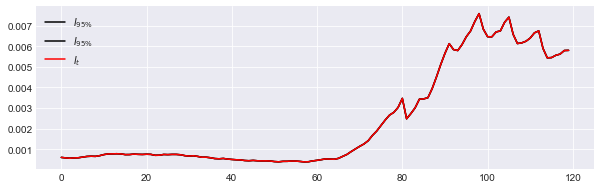

In [34]:
# generate trace from posterior
ppc_trace = pm.sample_posterior_predictive(trace, model=model)

# plot with data
plt.figure(figsize=(10, 3))
plt.plot(np.percentile(ppc_trace["EM"], [2.5, 97.5], axis=0).T, "k", label=r"$I_{95\%}$")
plt.plot(infected_obs, "r", label=r"$I_t$")
plt.legend()

In [35]:
simga_2_ep = sum(np.diff(infected_obs)**2)/(Dt*sum((infected_obs**2)+(1-infected_obs)**2))
np.sqrt(simga_2_ep)

0.0002451541367431264

In [36]:
def trayectorias(infected_obs,theta_est):
    Dt = 1 # time step
    N = len(infected_obs)-1
    i0 = infected_obs[0]
    x = i0 # initial proportion of infected 
    x_t_est = []

    # simulate
    for i in range(N):
        x = x + (x*(theta_est[0]-(x*theta_est[1])))*Dt + theta_est[2] * (x-x**2) * np.random.normal()*np.sqrt(Dt)
        x_t_est.append(x)
    x_t_est = np.array(x_t_est) # convert the values into an array
    x_t_est=np.insert(x_t_est,0,i0,axis=0) # add the initial condition at the beginning of the array
    return  np.abs(x_t_est)

Text(0.5, 1.0, 'Periodo 5, Trayectoria 1 \n error cuadratico medio: 8.822528854746557e-06')

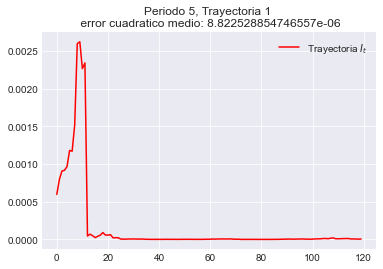

In [37]:
aa=trayectorias(infected_obs,theta_est)
msr_aa=mean_squared_error(infected_obs,aa)
plt.plot(trayectorias(infected_obs,theta_est), "r", label=r"Trayectoria $I_t$")
plt.legend()
plt.title("Periodo 5, Trayectoria 1 \n error cuadratico medio: "+ str(msr_aa))

In [38]:
mc = 10000
mse_est = []
i=0
# iterate through folder 1 to 34
    # try we are able to read the file
while i < mc:
    try :
        mse_ = mean_squared_error(infected_obs,trayectorias(infected_obs,theta_est))
        mse_est.append(mse_)
        i+=1
        # if any error occurs, skip this step and continue.
    except ValueError:
        mse_ = np.nan
        mse_est.append(mse_)
    continue

C:\Users\sebas\AppData\Local\Temp\ipykernel_12504\2925771409.py:10: RuntimeWarning:

overflow encountered in double_scalars

C:\Users\sebas\AppData\Local\Temp\ipykernel_12504\2925771409.py:10: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\sebas\AppData\Local\Temp\ipykernel_12504\2925771409.py:10: RuntimeWarning:

overflow encountered in double_scalars

C:\Users\sebas\AppData\Local\Temp\ipykernel_12504\2925771409.py:10: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\sebas\AppData\Local\Temp\ipykernel_12504\2925771409.py:10: RuntimeWarning:

overflow encountered in double_scalars

C:\Users\sebas\AppData\Local\Temp\ipykernel_12504\2925771409.py:10: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\sebas\AppData\Local\Temp\ipykernel_12504\2925771409.py:10: RuntimeWarning:

overflow encountered in double_scalars

C:\Users\sebas\AppData\Local\Temp\ipykernel_12504\2925771409.py:10: RuntimeWarning:

invalid value encountered

In [39]:
newlist = [x for x in mse_est if pd.isnull(x) == False]
newlist_1 = [x for x in newlist if np.isinf(x) == False]

In [40]:
newlist_1.sort(reverse=True)


In [41]:
len(newlist_1)

9994

In [42]:
np.mean(newlist_1)

1.0249092520543588e+174

In [43]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Mon Nov 07 2022

Python implementation: CPython
Python version       : 3.10.4
IPython version      : 8.4.0

scipy     : 1.7.3
sys       : 3.10.4 | packaged by conda-forge | (main, Mar 30 2022, 08:38:02) [MSC v.1916 64 bit (AMD64)]
arviz     : 0.12.1
matplotlib: 3.5.1
numpy     : 1.22.3
plotly    : 5.10.0
pandas    : 1.4.3
theano    : 1.1.2
pymc3     : 3.11.4

Watermark: 2.3.1

